# Environment setup

In [1]:
from scipy.io import loadmat
import os
import numpy as np
import mne

# Path to musicImagery dataset
dataDir = r'data/musicImagery'
#dataDir = r'D:\marion_music_imagery\datasetCND_musicImagery\musicImagery'

In [2]:
%matplotlib widget

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

// This disables scrolling outputs

<IPython.core.display.Javascript object>

# Load stimuli
Note: ```stimIndxs``` range from 1 to 4 and ```condIdxs``` range from 1-2.
These are _not_ 0-indexed.

In [4]:
stim_mat = loadmat(dataDir+r"/dataCND/dataStim.mat", simplify_cells = True) 
stim = stim_mat['stim']
# print(stim)

stimIdxs = stim['stimIdxs']
print(f'stimIdxs shape (N trials): {stimIdxs.shape}')

condIdxs = stim['condIdxs']
print(f'condIdxs shape (N trials): {condIdxs.shape}')

condNames = stim['condNames']
print(f'condNames shape (P conditions): {condNames.shape}')

events = stim['data']
print(f'events shape (M features, N trials): {events.shape}')

event_labels = stim['names']
print(f'event names shape (M features): {event_labels.shape}')

fs_stim = stim['fs'] # ignore, use fs from data struct (64 Hz)
print(f'fs: {fs_stim} Hz')

stimIdxs shape (N trials): (88,)
condIdxs shape (N trials): (88,)
condNames shape (P conditions): (2,)
events shape (M features, N trials): (2, 88)
event names shape (M features): (2,)
fs: 64 Hz


In [5]:
# Handy mapping of indices to labels
stimId_to_Song_map = {4: 'chor-019', 2: 'chor-038', 1:'chor-096', 3:'chor-101'} # from read_stim_midi.ipynb
condId_to_State_map = {1: 'Listening', 2: 'Imagery'} # from condNames

# Collect stim idxs by condition and song
idxs = {} # dict to store idxs for each condition and stim/song idx

for condIdx in np.unique(condIdxs): # two conditions
    condName = condNames[condIdx-1] # MATLAB indexes from 1...
    idxs[condName] = {}
    
    for stimIdx in np.unique(stimIdxs):
        
        stimName = stimId_to_Song_map[stimIdx]
        
        print(f'{condName}: Song {stimName}: Indices:') 
        matched_ndx = np.where(
            (stimIdxs == stimIdx) & (condIdxs == condIdx)
            )[0]
        print(matched_ndx)
        
        idxs[condName][stimName] = matched_ndx

Listening: Song chor-096: Indices:
[ 0  1  2  3  4  5  6  7  8  9 10]
Listening: Song chor-038: Indices:
[11 12 13 14 15 16 17 18 19 20 21]
Listening: Song chor-101: Indices:
[22 23 24 25 26 27 28 29 30 31 32]
Listening: Song chor-019: Indices:
[33 34 35 36 37 38 39 40 41 42 43]
Imagery: Song chor-096: Indices:
[44 45 46 47 48 49 50 51 52 53 54]
Imagery: Song chor-038: Indices:
[55 56 57 58 59 60 61 62 63 64 65]
Imagery: Song chor-101: Indices:
[66 67 68 69 70 71 72 73 74 75 76]
Imagery: Song chor-019: Indices:
[77 78 79 80 81 82 83 84 85 86 87]


# Load EEG data for a subject

In [6]:
# Select a subject (21 total)
subjectID = 1

# Path to data for selected subject
sub1_mat = loadmat(dataDir+f"/dataCND/dataSub{subjectID}.mat", simplify_cells = True) 

# This should be the same as fs_stim above
fs = sub1_mat['eeg']['fs']
print(f'fs: {fs} Hz')

# EEG dataset for selected subject
data = sub1_mat['eeg']['data']
print(f'data shape: {data.shape}')

# Randomized trial order for current subject
orig_trial_pos = sub1_mat['eeg']['origTrialPosition']
print(f'orig_trial_pos shape: {orig_trial_pos.shape}')

# EEG channel map
chanLocs = sub1_mat['eeg']['chanlocs']
assert len(chanLocs) == 64

fs: 64 Hz
data shape: (88,)
orig_trial_pos shape: (88,)


In [21]:
chanLocs[0]

{'Y': 0.30883,
 'X': 0.95048,
 'Z': -0.034899,
 'labels': 'Fp1',
 'sph_theta': 18.00001784,
 'sph_phi': -1.999965382,
 'sph_radius': 1.00000307,
 'theta': -18.00001784,
 'radius': 0.511110919,
 'urchan': 93}

# Average eye blinks by song and condition (task)
Trials matching this song and task will be stitched into a raw array object for MNE.

Subject1 stim order: [1 1 2 2 3 3 3 4 1 1 1 1 1 2 3 4 4 4 1 2 2 3 1 1 2 3 3 4 4 4 3 3 4 2 2 3 1
 1 1 1 2 2 2 3 2 2 3 3 4 2 2 3 4 4 4 1 3 4 4 1 2 2 3 3 3 4 1 2 2 3 4 2 3 3
 4 4 4 1 1 1 2 1 1 2 3 4 4 4]
Subject1 cond order: [1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 1 1 1 2
 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 2 2 2
 2 2 2 1 1 1 1 2 2 2 2 2 2 2]


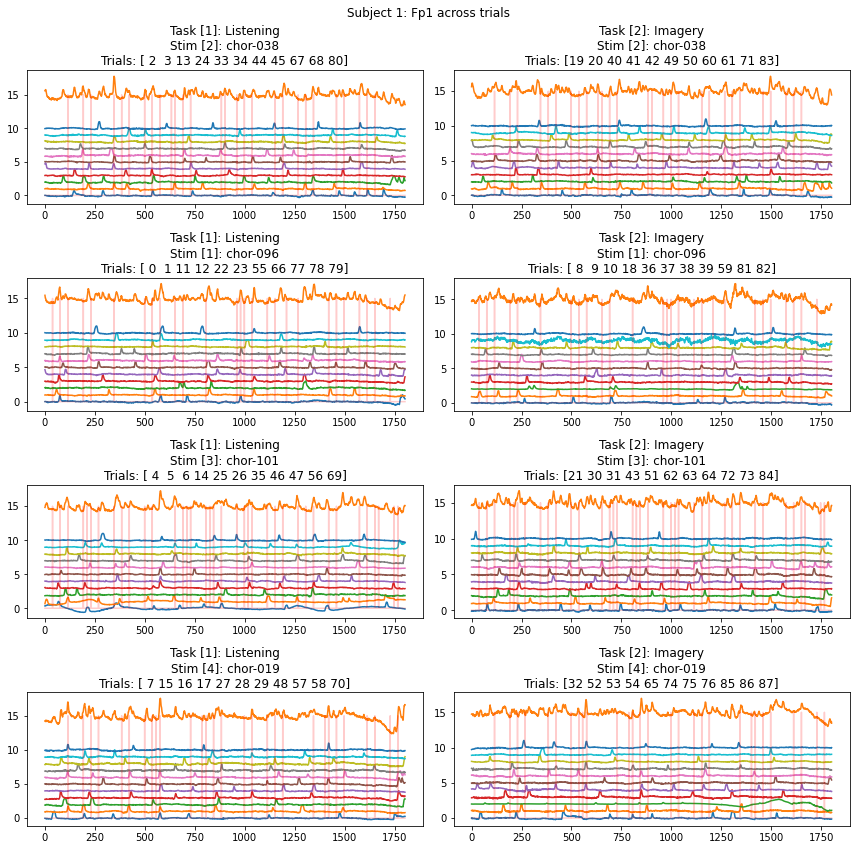

In [83]:
# Get current subject's song and condition ordering (since its randomized)
thisSubStimOrder = stimIdxs[(orig_trial_pos-1)] # convert to being zero indexed
thisSubCondOrder = condIdxs[(orig_trial_pos-1)]
print(f'Subject{subjectID} stim order: {thisSubStimOrder}')
print(f'Subject{subjectID} cond order: {thisSubCondOrder}')

# Get number of trials
N_reps = 11

# Collect Fp1 data for all songs and conditions
plt.figure(figsize=(12, 12))
pltIdx = 1

# Fp1 channel index
chIdx = 0

for stimIdx in [2, 1, 3, 4]: # top to bottom on the sheet music
    for condIdx in np.unique(condIdxs):
        
        # Find trials matching this song and condition
        trialsToEpoch = np.where(
            (thisSubStimOrder == stimIdx) & (thisSubCondOrder == condIdx)
        )[0]
        
        # Plot Fp1 data for these trials
        plt.subplot(4, 2, pltIdx)
        offset = 0
        
        # Container for collecting average across trials
        fp1_avg = np.zeros_like(data[0][:, chIdx])
        
        for trialIdx in trialsToEpoch:
            # Get Fp1 data
            fp1_data = data[trialIdx][:, chIdx]
            
            # Normalize
            fp1_data /= np.max(np.abs(fp1_data))
            
            # Plot and add an offset for each trial
            plt.plot(fp1_data + offset) # chan0 is FP1
            offset += 1 # increment offset for next run
            
            # Average
            fp1_avg += fp1_data / N_reps
            
        # Plot the average
        # print(fp1_avg)
        plt.plot(10 * fp1_avg + 15)
        
        # Plot the onsets
        stimExp = events[1][11*(stimIdx-1)] # expectations vector for current stim
        plt.plot(15 * ( > 0), 'r', alpha=0.2) # 1 = expectations
                
        condName = condId_to_State_map[condIdx]
        stimName = stimId_to_Song_map[stimIdx]

        title_str = '' #'='*50 + '\n'
        # title_str += f'Subject\t{subjectID}\n'
        title_str += f'Task [{condIdx}]: {condName}\n'
        title_str += f'Stim [{stimIdx}]: {stimName}\n'
        title_str += f'Trials: {trialsToEpoch}'
        plt.title(title_str)
        #print(title_str)
        
        pltIdx += 1

plt.suptitle(f'Subject {subjectID}: Fp1 across trials')
plt.tight_layout()